In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

In [ ]:
#import dataset
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Titanium_Alloy_UC.csv', encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [ ]:
fatigue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,860.00,932,0.0,25,704,2.0,0.0,0.5,60.0,89.148,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,850.00,925,1.0,25,700,2.0,0.0,0.5,50.0,89.140,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,800.00,932,0.0,25,704,2.0,0.0,0.5,60.0,89.148,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,780.00,925,1.0,25,700,2.0,0.0,0.5,50.0,89.140,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,699.00,0,0.0,25,700,2.0,0.0,0.5,90.0,89.100,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,915.24,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,910.82,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,907.55,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,900.00,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [ ]:
!pip install pyro-ppl

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

class BNN(PyroModule):
    def __init__(self, in_dim=22, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

# Coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1


Sample: 100%|██████████| 200/200 [23:36,  7.08s/it, step size=5.35e-03, acc. prob=0.964]


Pearson CC: 0.9525824043130372
R2 score: 0.8955298613873601
RMSE: 0.5750743617103344
MAE: 0.4112075128935484
Coverage: 95.45454545454544
Interval Width: 2.2871882915496826
Composite Metric: 0.8252136028828788


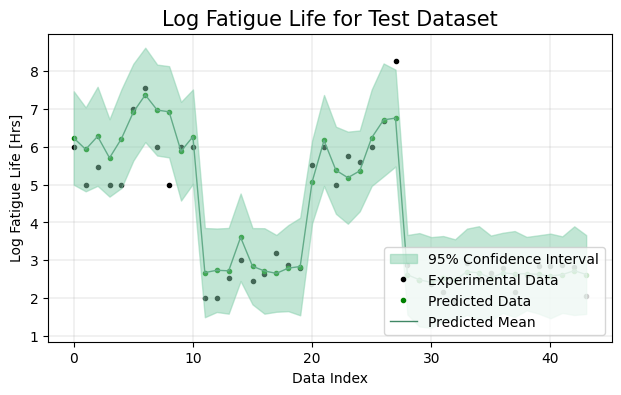

********************
Run # 1 Fold # 2


Sample: 100%|██████████| 200/200 [23:07,  6.94s/it, step size=5.74e-03, acc. prob=0.946]


Pearson CC: 0.9776340939070052
R2 score: 0.9421721953193692
RMSE: 0.4569384467658571
MAE: 0.3692358050788428
Coverage: 99.99999999999999
Interval Width: 2.372905731201172
Composite Metric: 0.8553560605938817


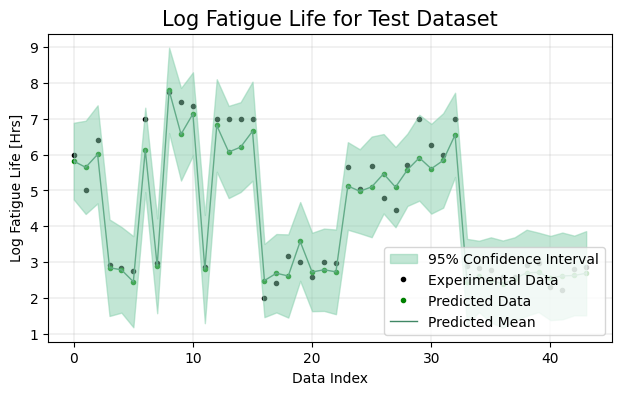

********************
Run # 1 Fold # 3


Sample: 100%|██████████| 200/200 [23:56,  7.18s/it, step size=5.40e-03, acc. prob=0.965]


Pearson CC: 0.9366500640106943
R2 score: 0.8770144392414947
RMSE: 0.6698134093047501
MAE: 0.4386759314717507
Coverage: 88.63636363636363
Interval Width: 2.3505516052246094
Composite Metric: 0.7711307410446099


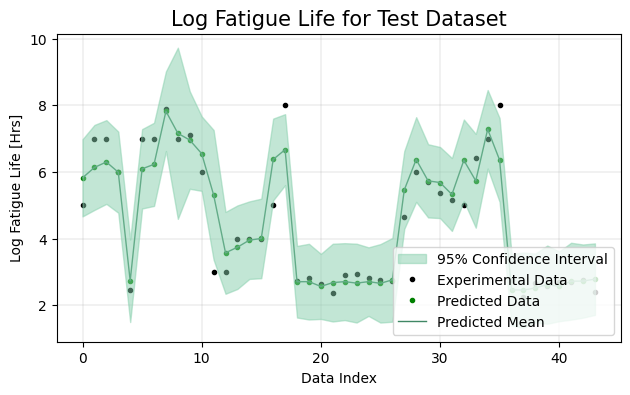

********************
Run # 1 Fold # 4


Sample: 100%|██████████| 200/200 [15:43,  4.72s/it, step size=7.93e-03, acc. prob=0.884]


Pearson CC: 0.9230660954963723
R2 score: 0.851409821316384
RMSE: 0.6634321076048884
MAE: 0.5028999066821975
Coverage: 90.90909090909089
Interval Width: 2.2661855220794678
Composite Metric: 0.7921357165320203


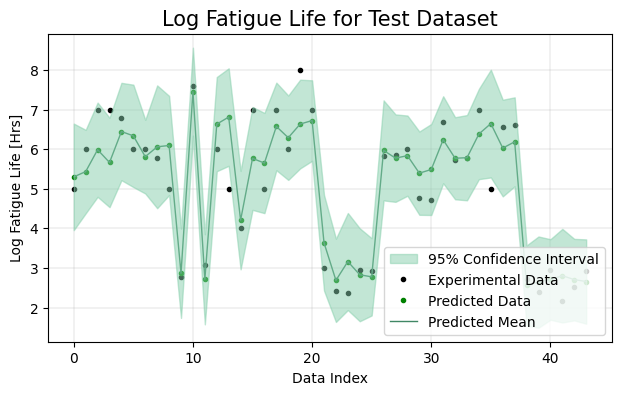

********************
Run # 1 Fold # 5


Sample: 100%|██████████| 200/200 [23:54,  7.17s/it, step size=3.76e-03, acc. prob=0.982]


Pearson CC: 0.9562048716618312
R2 score: 0.9088263343183879
RMSE: 0.6089148441937404
MAE: 0.41497036468118276
Coverage: 88.63636363636363
Interval Width: 2.324514150619507
Composite Metric: 0.7723220833105782


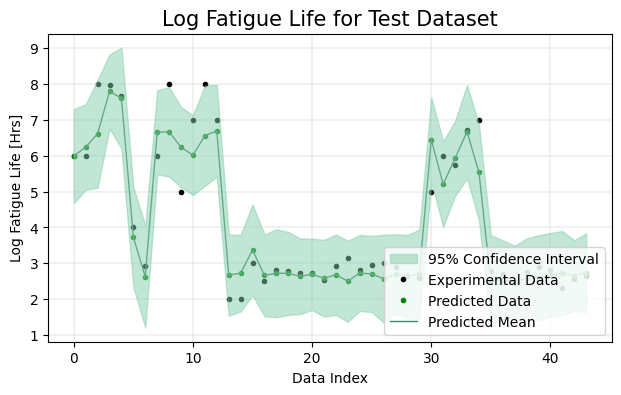

********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            # define DNN
            model = BNN(hid_dim=20, n_hid_layers=4, prior_scale=1)
            nuts_kernel = NUTS(model, jit_compile=False)
            mcmc = MCMC(nuts_kernel, num_samples=100)
            mcmc.run(torch.Tensor(x_train), torch.Tensor(y_train.to_numpy()))

            # evaluate the model on test data
            predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
            preds = predictive(torch.Tensor(x_test))
            y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
            y_std = preds['obs'].T.detach().numpy().std(axis=1)
            iteration_list = [i for i in range(len(y_test))]

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            ## Uncertainty quantification plot
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.952582,0.895530,0.575074,0.411208
1,0.977634,0.942172,0.456938,0.369236
2,0.936650,0.877014,0.669813,0.438676
3,0.923066,0.851410,0.663432,0.502900
4,0.956205,0.908826,0.608915,0.414970


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std
                   },index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.949228,0.01849,0.894991,0.030464,0.594835,0.077371,0.427398,0.04388


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,95.454545,2.287188,0.825214
1,100.000000,2.372906,0.855356
2,88.636364,2.350552,0.771131
3,90.909091,2.266186,0.792136
4,88.636364,2.324514,0.772322


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,92.727273,4.406982,2.320269,0.039307,0.803232,0.032586
